In [1]:
import torch
from datasets import load_dataset
from torchvision.transforms.v2 import Resize, Compose, ToImage, ToDtype

image_size = 256

dataset = load_dataset("tanganke/stanford_cars")

train_set = dataset['train']
test_set = dataset['test']

transform = Compose([
    Resize((image_size, image_size)),
    ToImage(),
    ToDtype(torch.float32, scale=True),
])

def preprocess(data):
    data['image'] = transform(data['image'])
    return data

train_set.set_transform(preprocess)
test_set.set_transform(preprocess)

143
torch.Size([3, 256, 256])


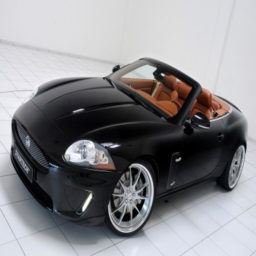

In [2]:
from random import randint
from torchvision.transforms.v2.functional import to_pil_image

i = randint(0, len(train_set))
sample = train_set[i]
image, label = sample['image'], sample['label']

print(label)
print(image.shape)

to_pil_image(image)

In [3]:
from torch.utils.data import DataLoader

def custom_collate_fn(batch):
    images = [item['image'] for item in batch]
    labels = [item['label'] for item in batch]
    
    for i in range(len(images)):
        if images[i].size(0) == 1:
            images[i] = images[i].repeat(3, 1, 1)
    
    images = torch.stack(images)
    labels = torch.tensor(labels)
    
    return {'image': images, 'label': labels}

train_loader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=4, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False, num_workers=4, collate_fn=custom_collate_fn)

In [4]:
from models import SwinTransformerV1, SwinTransformerV2

swin_transformer = SwinTransformerV2(
    hidden_dim=128,
    layers=(2, 2, 18, 2),
    heads=(4, 8, 16, 32),
    image_size=image_size,
    window_size=8,
).cuda()

image = next(iter(train_loader))['image'].cuda()
out = swin_transformer(image)
out.shape

dots shape: torch.Size([16, 4, 64, 64, 64])
tau shape: torch.Size([1, 4, 1, 1, 1])
dots shape: torch.Size([16, 4, 64, 64, 64])
tau shape: torch.Size([1, 4, 1, 1, 1])
dots shape: torch.Size([16, 8, 16, 64, 64])
tau shape: torch.Size([1, 8, 1, 1, 1])
dots shape: torch.Size([16, 8, 16, 64, 64])
tau shape: torch.Size([1, 8, 1, 1, 1])
dots shape: torch.Size([16, 16, 4, 64, 64])
tau shape: torch.Size([1, 16, 1, 1, 1])
dots shape: torch.Size([16, 16, 4, 64, 64])
tau shape: torch.Size([1, 16, 1, 1, 1])
dots shape: torch.Size([16, 16, 4, 64, 64])
tau shape: torch.Size([1, 16, 1, 1, 1])
dots shape: torch.Size([16, 16, 4, 64, 64])
tau shape: torch.Size([1, 16, 1, 1, 1])
dots shape: torch.Size([16, 16, 4, 64, 64])
tau shape: torch.Size([1, 16, 1, 1, 1])
dots shape: torch.Size([16, 16, 4, 64, 64])
tau shape: torch.Size([1, 16, 1, 1, 1])
dots shape: torch.Size([16, 16, 4, 64, 64])
tau shape: torch.Size([1, 16, 1, 1, 1])
dots shape: torch.Size([16, 16, 4, 64, 64])
tau shape: torch.Size([1, 16, 1, 1, 

torch.Size([16, 1024, 8, 8])

In [ ]:
import lightning as l

from models import SwinTransformerV1, SwinTransformerV2
from models.classifier import SwinClassifier

from lightning.pytorch.loggers import TensorBoardLogger
from callbacks import (
    ScoringCallback,
    ProgressBarCallback,
    TimerCallback,
)

torch.set_float32_matmul_precision('medium')

swin_transformer = SwinTransformerV1(
    hidden_dim=128,
    layers=(2, 2, 18, 2),
    heads=(4, 8, 16, 32),
    window_size=8,
)
model = SwinClassifier(
    swin_transformer=swin_transformer,
    num_classes=196,
    max_epochs=100,
)

logger = TensorBoardLogger(save_dir="logs", name="swin_classifier")

trainer = l.Trainer(
    accelerator="auto",
    max_epochs=model.max_epochs,
    log_every_n_steps=100,
    check_val_every_n_epoch=10,
    logger=logger,
    gradient_clip_val=1.0,
    gradient_clip_algorithm="norm",
    callbacks=[
        ScoringCallback(),
        ProgressBarCallback(),
        TimerCallback(),
    ],
)

In [ ]:
trainer.fit(model, train_loader, test_loader)

In [ ]:
trainer.test(model, test_loader)